C:\Users\takah\AppData\Local\Temp\ipykernel_19200\906010674.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values('Date', inplace=True)
C:\Users\takah\AppData\Local\Temp\ipykernel_19200\906010674.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Return_{i}'] = data['Close'].pct_change()


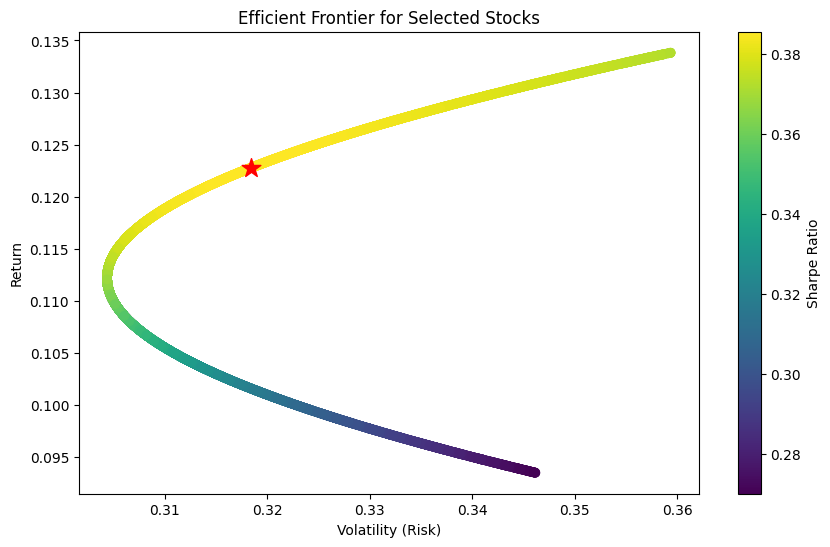

Maximum Sharpe Ratio Portfolio:
Return          0.122771
Risk            0.318384
Sharpe Ratio    0.385608
Weight_0        0.274691
Weight_1        0.725309
Name: 8323, dtype: float64


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# データの読み込み
file_names = ["./gps.us.csv", "./rl.us.csv", "./abc.us.csv"]
stock_data = []

for file in file_names:
    data = pd.read_csv(file, delimiter=',')
    data['Date'] = pd.to_datetime(data['Date'])
    data = data[data['Date'] >= '2000-01-01']  # 2000年以降のデータにフィルタリング
    stock_data.append(data)

# 共通の日付範囲を取得
common_dates = stock_data[0][['Date']]
for data in stock_data[1:]:
    common_dates = pd.merge(common_dates, data[['Date']], on='Date', how='inner')

# 共通日付でフィルタリングし、リターンを計算
returns = pd.DataFrame({'Date': common_dates['Date']})
for i, data in enumerate(stock_data):
    data = data[data['Date'].isin(common_dates['Date'])]
    data.sort_values('Date', inplace=True)
    data[f'Return_{i}'] = data['Close'].pct_change()
    returns = pd.merge(returns, data[['Date', f'Return_{i}']], on='Date', how='inner')

returns.set_index('Date', inplace=True)
returns.dropna(inplace=True)

# 年間の平均収益率と共分散行列を計算
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

# モンテカルロシミュレーションの設定
num_portfolios = 10000
num_assets = len(stock_data)
results = np.zeros((3 + num_assets, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_stddev
    
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = sharpe_ratio
    for j in range(num_assets):
        results[3 + j, i] = weights[j]

# 結果をデータフレームに変換
columns = ['Return', 'Risk', 'Sharpe Ratio']
columns.extend([f'Weight_{i}' for i in range(num_assets)])
results_df = pd.DataFrame(results.T, columns=columns)

# NaNの行を削除
results_df.dropna(inplace=True)

# 最適ポートフォリオを見つける
if not results_df.empty:
    max_sharpe_idx = results_df['Sharpe Ratio'].idxmax()
    max_sharpe_portfolio = results_df.loc[max_sharpe_idx]

    # プロット
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['Risk'], results_df['Return'], c=results_df['Sharpe Ratio'], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Return')
    plt.scatter(max_sharpe_portfolio['Risk'], max_sharpe_portfolio['Return'], color='red', marker='*', s=200)  # マックスシャープレシオのポートフォリオ
    plt.title('Efficient Frontier for Selected Stocks')
    plt.show()

    print(f"Maximum Sharpe Ratio Portfolio:\n{max_sharpe_portfolio}")
else:
    print("No portfolios were generated after filtering out NaN values.")
